# Appendix 2: Qarn Alam Processing

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from pyproj import Proj, transform
import matplotlib.cm as cm
from scipy.interpolate import griddata
import matplotlib.patches as mpatches
import datetime
import numpy.ma as ma

### Loading SARPROZ csv file

In [2]:
d = np.loadtxt("newest_star.csv", delimiter=",", skiprows=1, dtype=str)
# entries
print d[0]

['ID' 'LAT' 'LON' 'HEIGHT' 'HEIGHT WRT DEM' 'SIGMA HEIGHT' 'VEL'
 'SIGMA VEL' 'SEASONAL' 'CUMUL.DISP.' 'COHER' 'SVET' 'LVET' 'IN' 'FIN'
 'STDEV' '20140418' '20140512' '20140605' '20140629' '20140723' '20140816'
 '20141003' '20141027' '20141120' '20141214' '20150107' '20150131'
 '20150224' '20150320' '20150413' '20150531' '20150624' '20150718'
 '20150811' '20150904' '20150928' '20151209' '20160102' '20160126'
 '20160219' '20160314' '20160407' '20160501' '20160525' '20160618'
 '20160712' '20160805' '20160829' '20160922' '20161016' '20161109'
 '20161203' '20161227']


### Aqcuisition time

In [3]:
# Obtaining sar acuisition time starting from 20140418
insar_obs_t= d[0][np.where(d[0]=='20140418')[0][0]:]
print insar_obs_t
# converting time to julian date
fmt = '%Y%m%d'
QA_jul_date=[]
for i in insar_obs_t:
    dt = datetime.datetime.strptime(i, fmt)
    tt = dt.timetuple()
    QA_jul_date.append(tt.tm_year+(tt.tm_yday/365.))

['20140418' '20140512' '20140605' '20140629' '20140723' '20140816'
 '20141003' '20141027' '20141120' '20141214' '20150107' '20150131'
 '20150224' '20150320' '20150413' '20150531' '20150624' '20150718'
 '20150811' '20150904' '20150928' '20151209' '20160102' '20160126'
 '20160219' '20160314' '20160407' '20160501' '20160525' '20160618'
 '20160712' '20160805' '20160829' '20160922' '20161016' '20161109'
 '20161203' '20161227']


### Transforming PS coordinates to PSD93

In [5]:
# Dictionary to save filtered PS points
flt_insar={'lat':[],'lon':[],'Easting':[],'Northing':[],'vel':[]}
lat = []
lon = []

# loop to go through all dates
for n,t in enumerate(insar_obs_t):
# lists to save coordinates, vel and time series
    flt_insar['%s'%t]=[]
    flt_insar['lat']=[]
    flt_insar['lon']=[]
    flt_insar['vel']=[]
# loop to go through all PS
    for i in xrange(1,len(d)):
# select only PS that with STDEV of less than 1.7
        if float(d[i][15])<1.7:
# obraining displacement for that PS and that date ..
# converted from LOS to vertical
            ds=float(d[i][np.where(d[0]==t)[0][0]])*\
            (1/np.cos(np.radians(32.47)))
            flt_insar[t].append(ds)
# saving vel, lat, long
            v = float(d[i][6])*(1/np.cos(np.radians(32.47)))
            flt_insar['vel'].append(v)
            flt_insar['lat'].append(float(d[i][1]))
            flt_insar['lon'].append(float(d[i][2]))
        else:
            pass
        
# transforming PS coordinates from wGS84 to PSD93      
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3440')
flt_insar['Easting'], flt_insar['Northing'] = transform\
(inProj, outProj, flt_insar['lon'], flt_insar['lat'])
xmin=min(flt_insar['Easting'])
ymin=min(flt_insar['Northing'])
xmax=max(flt_insar['Easting'])
ymax=max(flt_insar['Northing'])
print xmin, ymin, xmax, ymax

501004.561351 2344744.42394 519296.633457 2363561.31762


### Interpolating PSs to obtain deformation map

/home/moath/anaconda3/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


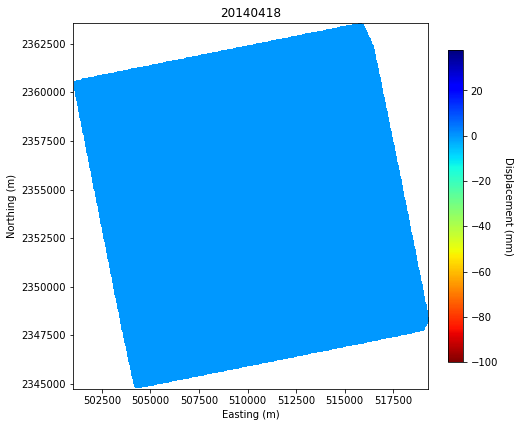

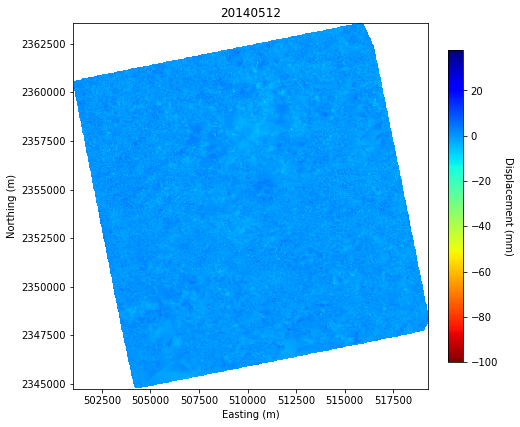

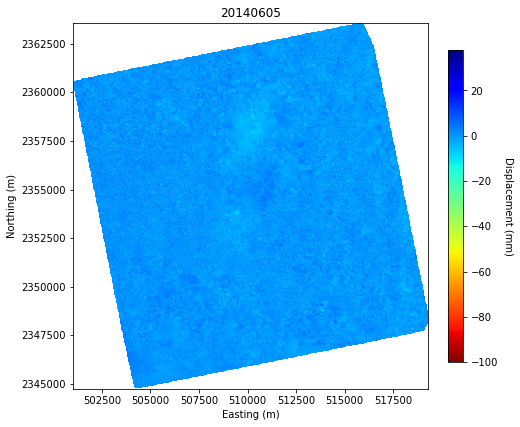

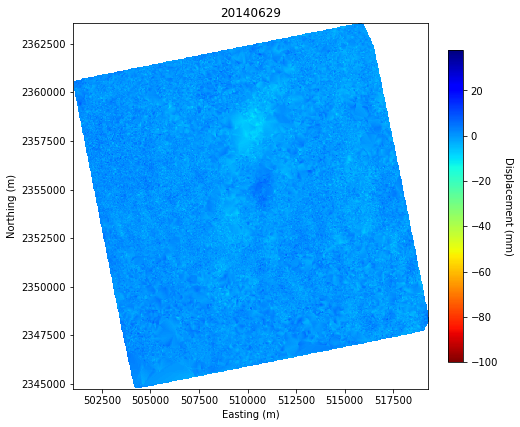

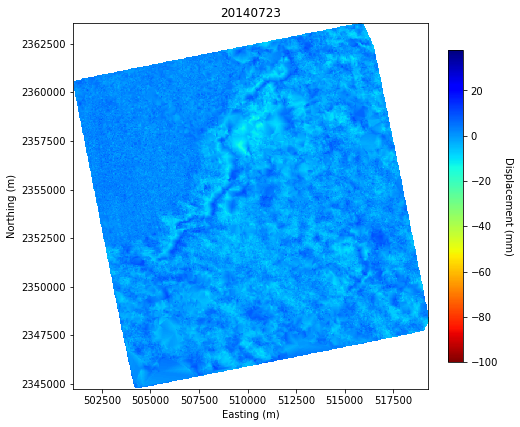

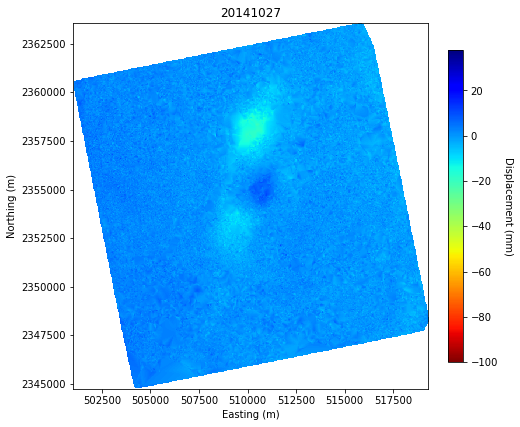

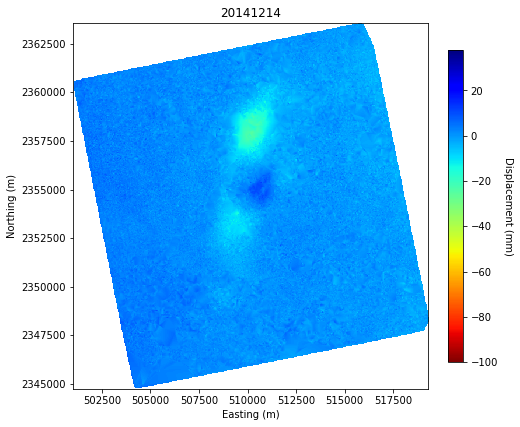

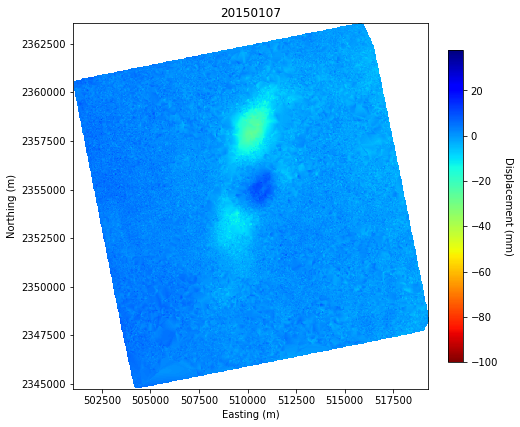

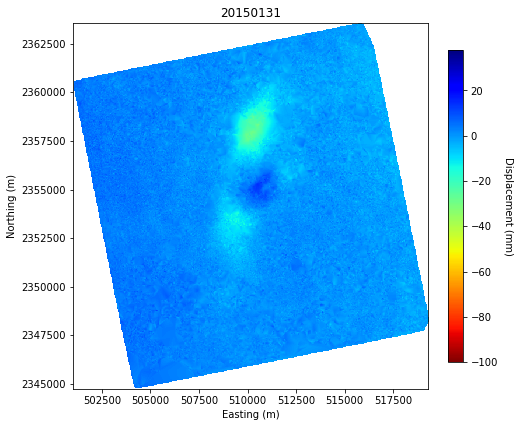

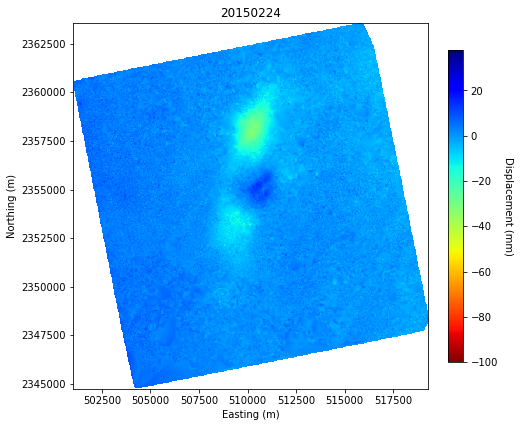

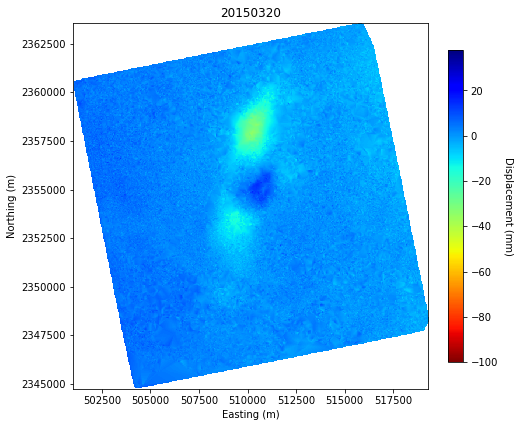

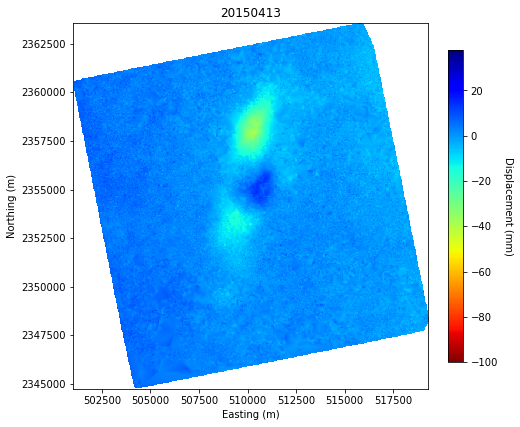

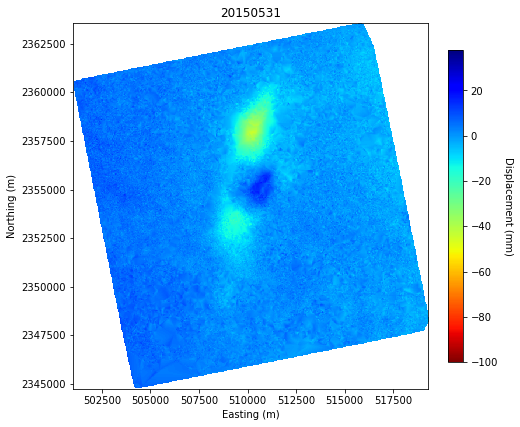

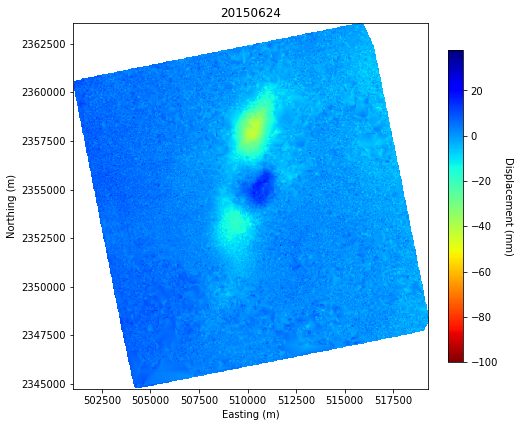

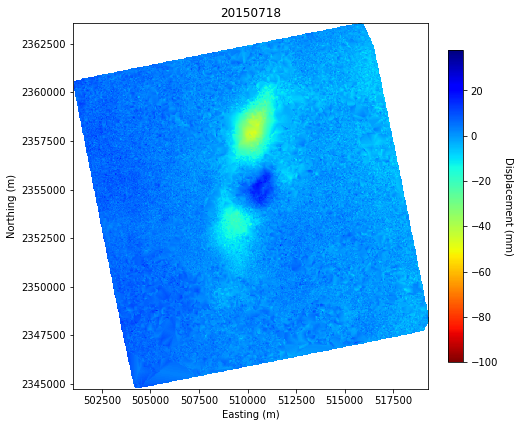

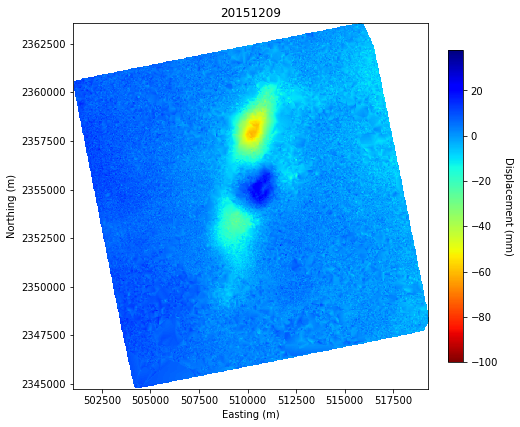

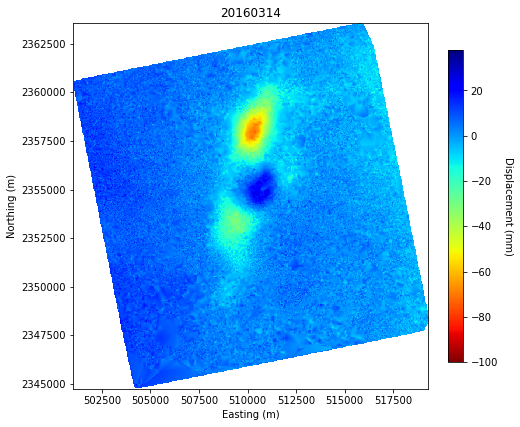

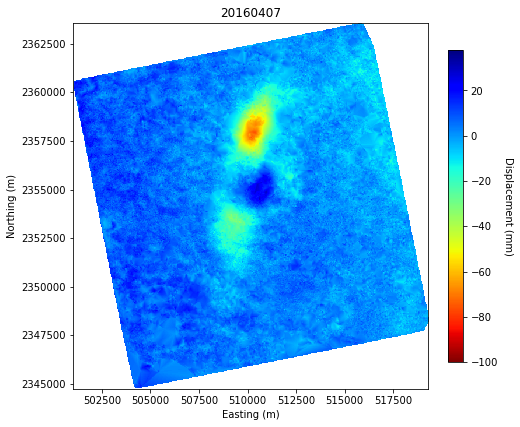

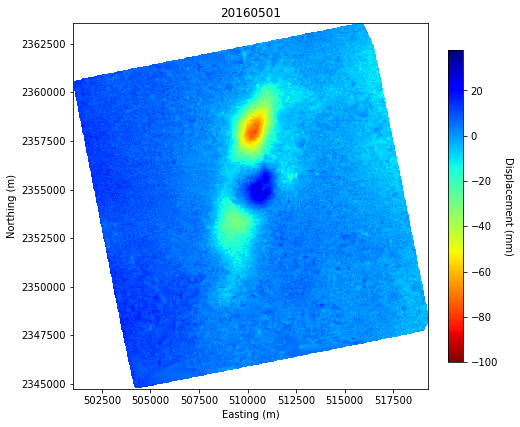

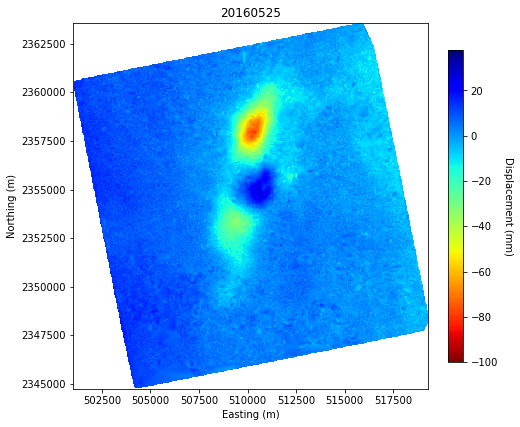

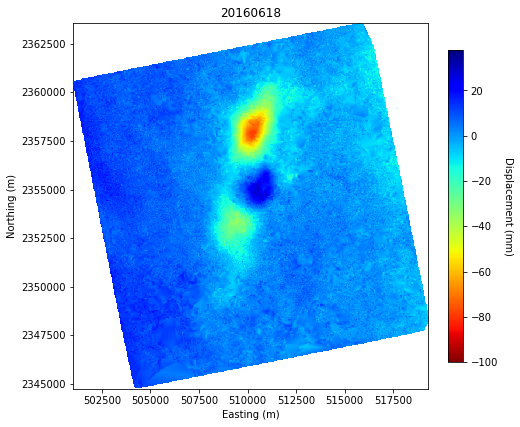

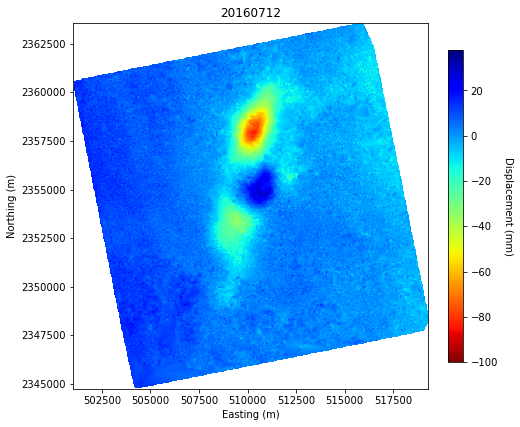

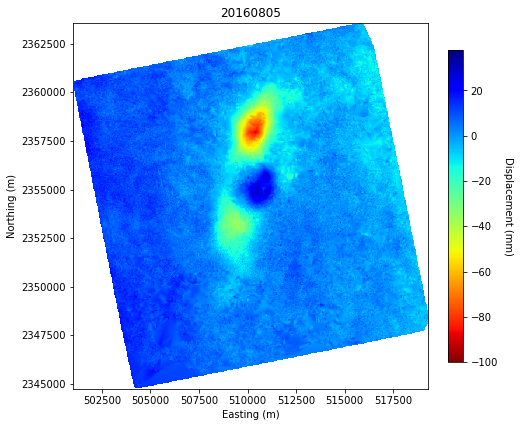

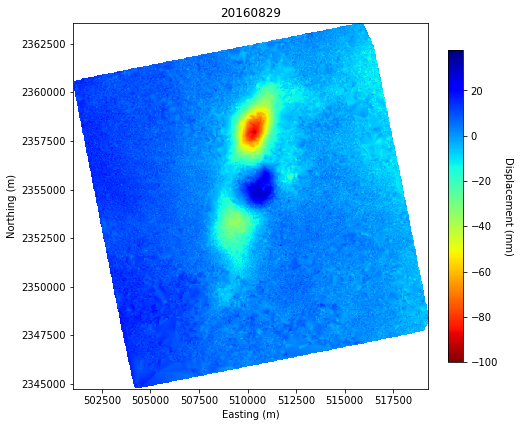

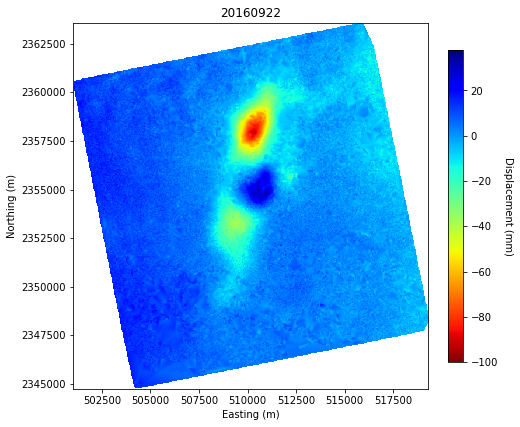

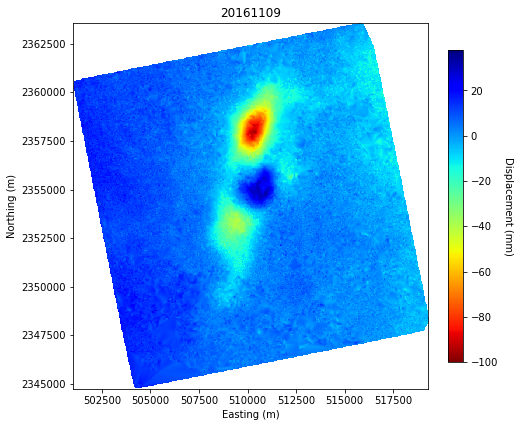

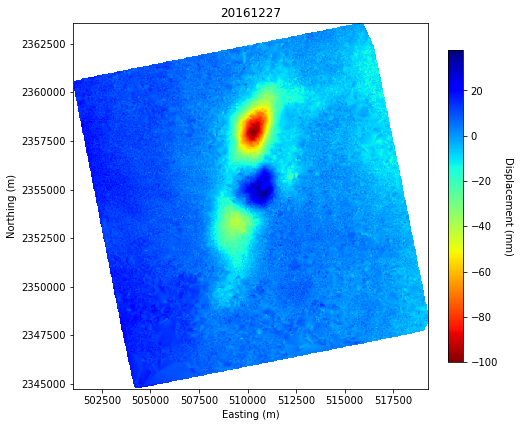

In [6]:
# Dictionary to save deformation maps
insar_grids={}
# cell size of the deformation map
cell_size=30
# obtaining grid coordinates
grid_x, grid_y = np.mgrid[xmin:xmax:cell_size, ymin:ymax:cell_size]
# loop to interpolate each date
for i in insar_obs_t:
# interpolating using griddata
    insar_grids[i]=[]
    grid=griddata((flt_insar['Easting'],flt_insar['Northing'])\
                  , flt_insar[i], (grid_x, grid_y), method='linear')
    insar_grids[i] = grid.T
# plotting the deformation map
    plt.figure(figsize=(7,7))
    plt.title(i)
    #print min(flt_insar[i]),max(flt_insar[i])
    plt.imshow(insar_grids[i], cmap=cm.jet_r, extent=[xmin, xmax,\
            ymin, ymax], vmin=-100,vmax=38,origin='lower')
    plt.xlabel('Easting (m)')
    plt.ylabel('Northing (m)')
    cbar=plt.colorbar(fraction=0.04, pad=0.05)
    cbar.set_label('Displacement (mm)', rotation=270,labelpad=15)
    plt.savefig('images/QA%s.jpg'%(i),bbox_inches='tight')

### Ploting velocity map

-38.5101966148 14.4605847553


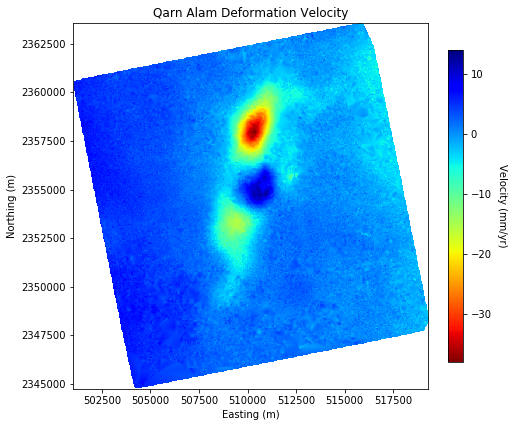

In [7]:
fig = plt.figure(figsize=(7,7))
# interpolating velocities from the filtered PSs
vel_grid =[]
vel_grid = griddata((flt_insar['Easting'],flt_insar['Northing'])\
            , flt_insar['vel'], (grid_x, grid_y), method='linear')
# plotting velocity map
plt.imshow(vel_grid.T,cmap=cm.jet_r,vmin=-38,vmax=14,extent=\
        [xmin, xmax, ymin, ymax],origin='lower')
print min(flt_insar['vel']),max(flt_insar['vel'])
plt.title('Qarn Alam Deformation Velocity')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
cbar=plt.colorbar(fraction=0.04, pad=0.05)
cbar.set_label('Velocity (mm/yr)', rotation=270,labelpad=15)
plt.savefig('images/QA_Vel.jpg',bbox_inches='tight')

In [8]:
print 'Total area affected by subsidence is %.3f km'%\
(len(np.where(vel_grid<-3)[0])*30.*30/(1000*1000))
print 'Total area affected by subsidence of more than 10 mm/yr is %.3f km'\
%(len(np.where(vel_grid<-10)[0])*30.*30/(1000*1000))
print 'Total area affected by subsidence of more than 20 mm/yr is %.3f km'\
%(len(np.where(vel_grid<-20)[0])*30.*30/(1000*1000))

Total area affected by subsidence is 30.451 km
Total area affected by subsidence of more than 10 mm/yr is 6.658 km
Total area affected by subsidence of more than 20 mm/yr is 2.238 km


/home/moath/anaconda3/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/moath/anaconda3/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/home/moath/anaconda3/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


### Obtaining total subsidence in sub area (south)

/home/moath/anaconda3/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less
/home/moath/anaconda3/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/home/moath/anaconda3/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less


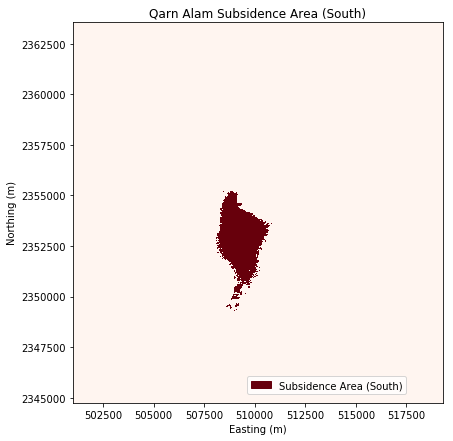

In [9]:
#array to only include pixels from subsidence area south
mask_sub_south =[]
mask_sub_south=np.zeros(vel_grid.T.shape)
# loop to find subsidence pixels in the south
for i in xrange(0,len(np.where(vel_grid.T<-3)[0])):
    if np.where(vel_grid.T<-3)[1][i]<350 and \
    np.where(vel_grid.T<-3)[0][i]<350:
        mask_sub_south[np.where(vel_grid.T<-3)[0][i]\
                ,np.where(vel_grid.T<-3)[1][i]]=5
# plotting the subsidence area (south)
fig = plt.figure(figsize=(7,7))
im= plt.imshow(mask_sub_south,cmap=cm.Reds,extent=\
            [xmin, xmax, ymin, ymax],origin='lower')
plt.title('Qarn Alam Subsidence Area (South)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
values = np.unique(mask_sub_south.ravel())
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[1], label=\
            "Subsidence Area (South)"%values[1])]
plt.legend(handles=patches, bbox_to_anchor=(0.47, 0.07)\
           , loc=2, borderaxespad=0. )
plt.savefig('images/mask_QA_sub_south.jpg',bbox_inches='tight')

# saving .txt of total subsidence in each date using a mask
masked=mask_sub_south==0
total_sub_south=[0]
sub_change_south=[0]
sub_south_file = open('QA_sub_south_11.txt', 'w')
for n,i in enumerate(sorted(insar_grids.keys())):
    if n ==0:
           sub_south_file.write("%.3f\t%.3f\t%.3f\t%.3f\n"\
                                %(QA_jul_date[n],0,0,0))
    else:
        
        disp_masked1=insar_grids['%s'%insar_obs_t[n]][~masked]
        disp_masked2=insar_grids['%s'%insar_obs_t[n-1]][~masked]
        sub=sum(disp_masked1)
        d=((QA_jul_date[n]-QA_jul_date[n-1]))
        change = (disp_masked1-disp_masked2)/d
        change_sum=sum(change[change<0])*-1
        mean = np.mean(change[change<0])*-1
        total_sub_south.append(sub)
        sub_change_south.append(change_sum)
        sub_south_file.write("%.3f\t%.3f\t%.3f\t%.3f\n"\
                %(QA_jul_date[n],sub,change_sum,mean))

In [11]:
fig = plt.figure(figsize=(7,7))
# interpolating velocities from the filtered PSs
masked=mask_sub_south==0
velo=ma.array(vel_grid.T,mask=masked)
# plotting velocity map
plt.imshow(velo,cmap=cm.jet_r,vmin=-38,vmax=14,extent=\
        [xmin, xmax, ymin, ymax],origin='lower')
plt.title('Qarn Alam South Velocity')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
cbar=plt.colorbar(fraction=0.04, pad=0.05)
cbar.set_label('Velocity (mm/yr)', rotation=270,labelpad=15)
(np.sum(mask_sub_south)/5)*(30.*30)/(1000*1000)
(np.sum(mask_sub_south)/5)*30.*30/(1000*1000)
print 'Total Area:',(np.sum(mask_sub_south)/10)*(30.*30)/(1000*1000),'and Max. sub Velocity:', np.min(velo)

Total Area: 3.59955 and Max. sub Velocity: -16.5202412321


### Obtaining total subsidence in sub area (North)

In [12]:
#array to only include pixels from subsidence area north
mask_sub_north =[]
mask_sub_north=np.zeros(vel_grid.T.shape)
# loop to find subsidence pixels in the north
for i in xrange(0,len(np.where(vel_grid.T<-3)[0])):
    if np.where(vel_grid.T<-3)[1][i]<400 and np.\
    where(vel_grid.T<-3)[0][i]>350:
        mask_sub_north[np.where(vel_grid.T<-3)[0][i]\
                ,np.where(vel_grid.T<-3)[1][i]]=10
# plotting the subsidence area (north)
fig = plt.figure(figsize=(7,7))
im=plt.imshow(mask_sub_north,cmap=cm.Reds,extent=\
        [xmin, xmax, ymin, ymax],origin='lower')
plt.title('Qarn Alam Subsidence Area (North)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
values = np.unique(mask_sub_north.ravel())
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[1], label=\
                "Subsidence Area (North)"%values[1])]
plt.legend(handles=patches, bbox_to_anchor=(0.47, 0.07)\
        , loc=2, borderaxespad=0. )
plt.savefig('images/mask_QA_sub_north.jpg',bbox_inches='tight')

# saving .txt of total subsidence in each date using a mask
masked=mask_sub_north==0
total_sub_north=[0]
sub_change_north=[0]
sub_north_file = open('QA_sub_north4.txt', 'w')
for n,i in enumerate(sorted(insar_grids.keys())):
    if n ==0:
           sub_north_file.write("%.3f\t%.3f\t%.3f\n"\
                                %(QA_jul_date[n],0,0))
    else:
        
        disp_masked1=insar_grids['%s'%insar_obs_t[n]][~masked]
        disp_masked2=insar_grids['%s'%insar_obs_t[n-1]][~masked]
        sub=sum(disp_masked1)
        d=((QA_jul_date[n]-QA_jul_date[n-1]))
        change = (disp_masked1-disp_masked2)/d
        change_sum=sum(change[change<0])*-1
        total_sub_north.append(sub)
        sub_change_north.append(change_sum)
        sub_north_file.write("%.3f\t%.3f\t%.3f\n"\
                %(QA_jul_date[n],sub,change_sum))

/home/moath/anaconda3/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less
/home/moath/anaconda3/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/home/moath/anaconda3/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less


Total Area: 14.8023 and Max. sub Velocity: -38.310515794


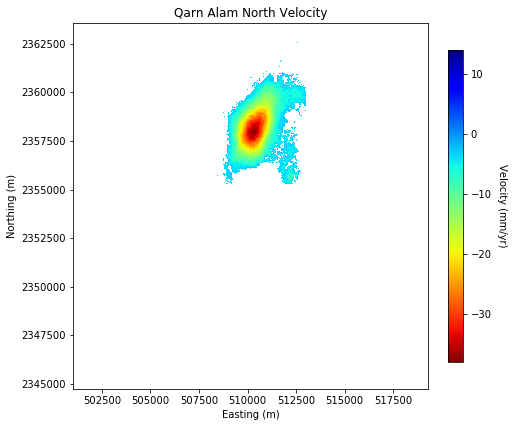

In [13]:
fig = plt.figure(figsize=(7,7))
# interpolating velocities from the filtered PSs
masked=mask_sub_north==0
velo=ma.array(vel_grid.T,mask=masked)
# plotting velocity map
plt.imshow(velo,cmap=cm.jet_r,vmin=-38,vmax=14,extent=\
        [xmin, xmax, ymin, ymax],origin='lower')
plt.title('Qarn Alam North Velocity')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
cbar=plt.colorbar(fraction=0.04, pad=0.05)
cbar.set_label('Velocity (mm/yr)', rotation=270,labelpad=15)
print 'Total Area:',(np.sum(mask_sub_north)/10)*(30.*30)/(1000*1000),'and Max. sub Velocity:', np.min(velo)

### Obtaining total uplift in uplift area

In [14]:
#array to only include pixels from uplift area
mask_uplift =[]
mask_uplift=np.zeros(vel_grid.T.shape)

# loop to find uplift pixels in uplift area
for i in xrange(0,len(np.where(vel_grid.T>2)[0])):
    if np.where(vel_grid.T>2)[1][i]>250 and np.where\
(vel_grid.T>2)[0][i]<400 and np.where(vel_grid.T>2)[0][i]>290\
and np.where(vel_grid.T>2)[1][i]<350:
        mask_uplift[np.where(vel_grid.T>2)[0][i],\
            np.where(vel_grid.T>2)[1][i]]=-10

# plotting the subsidence area (north)
fig = plt.figure(figsize=(7,7))
im=plt.imshow(mask_uplift,cmap=cm.Reds_r,extent=\
        [xmin, xmax, ymin, ymax],origin='lower')
plt.title('Qarn Alam Uplift Area')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
values = np.unique(mask_uplift.ravel())
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[0], label\
                    ="Uplift Area"%values[0])]
plt.legend(handles=patches, bbox_to_anchor=(0.67, 0.07)\
        , loc=2, borderaxespad=0. )
plt.savefig('images/mask_QA_uplift.jpg',bbox_inches='tight')
# saving .txt of total uplift in each date using a mask
masked=mask_uplift==0
total_uplift=[]
uplift_file = open('QA_uplift.txt', 'w')
for n,i in enumerate(sorted(insar_grids.keys())):
    disp_masked=insar_grids['%s'%i][~masked]
    total_up=sum(disp_masked)
    total_uplift.append(total_up)
    uplift_file.write("%f\t%f\n" %(QA_jul_date[n],total_up))


/home/moath/anaconda3/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/home/moath/anaconda3/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater
/home/moath/anaconda3/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


In [15]:
fig = plt.figure(figsize=(7,7))
# interpolating velocities from the filtered PSs
masked=mask_uplift==0
velo=ma.array(vel_grid.T,mask=masked)
# plotting velocity map
plt.imshow(velo,cmap=cm.jet_r,vmin=-38,vmax=14,extent=\
        [xmin, xmax, ymin, ymax],origin='lower')
plt.title('Qarn Alam Uplift Area Velocity')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
cbar=plt.colorbar(fraction=0.04, pad=0.05)
cbar.set_label('Velocity (mm/yr)', rotation=270,labelpad=15)
print 'Total Area:',(np.sum(mask_uplift)/-10)*(30.*30)/(1000*1000),'and Max. uplift Velocity:', np.max(velo)

Total Area: 2.9574 and Max. uplift Velocity: 13.4202138247


### plotting all deformation areas

/home/moath/anaconda3/lib/python2.7/site-packages/matplotlib/patches.py:121: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


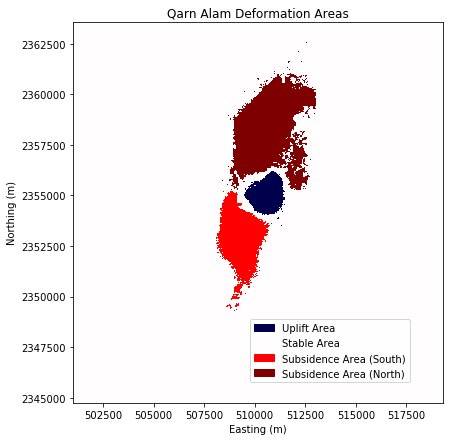

In [16]:
# obtaining an array of all areas
allmasks= mask_uplift+mask_sub_north+mask_sub_south
# plotting the array
fig = plt.figure(figsize=(7,7))
im=plt.imshow(allmasks,cmap=cm.seismic,origin='lower',\
              extent=[xmin, xmax, ymin, ymax])
plt.title('Qarn Alam Deformation Areas')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
values = np.unique(allmasks.ravel())
colors = [ im.cmap(im.norm(value)) for value in values]
texts=['Uplift Area','Stable Area','Subsidence Area (South)'\
       ,'Subsidence Area (North)']
patches = [ mpatches.Patch(color=colors[i],edgecolor='b',\
label="{l}".format(l=texts[i]) ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(0.48, 0.22),\
        loc=2, borderaxespad=0. )
plt.savefig('images/mask_QA_al.jpg',bbox_inches='tight')
